# How do CBCL Scores progress over time?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pygal
import seaborn as sns
from tqdm import tqdm
import abcd.utils.io as io
from abcd.local.paths import core_path, output_path
from abcd.data.SELF_REPORTED import MH_SCORES_t as MH_SCORES
from abcd.data.read_data import get_subjects_events, add_event_vars
from abcd.plotting.seaborn.scatter import plot_jointplot
from abcd.plotting.pygal.rendering import display_html

In [3]:
# Fetch subjects and events
# subjects_df, events_df = get_subjects_events()
subjects_df = io.load_df(output_path, "subjects_gi")
events_df = io.load_df(output_path, "events_gi")
print("There are initially {} subjects and {} visits".format(len(subjects_df), len(events_df)))
# Add mental health outcomes
mental_health_file = os.path.join(core_path, "mental-health", "mh_p_cbcl.csv")
mh_events_df = add_event_vars(events_df, mental_health_file, vars=list(MH_SCORES.keys()))
print("From those, there are {} visits with mental health scores".format(len(mh_events_df)))
# Remove missing values
mh_events_df = mh_events_df.dropna()
print("After removing missing values, the df has {} visits".format(len(mh_events_df)))

There are initially 11686 subjects and 88896 visits


c:\users\camgonza\desktop\abcd5\abcd\utils\io.py:24: DtypeWarning: Columns (124,128,132,136,140,144,148,152,156,160,164,168,172,176,180,184,188,192,196,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=sep)


From those, there are 47978 visits with mental health scores
After removing missing values, the df has 42780 visits


In [4]:
# Plot distribution of variables
plot = pygal.Box()
plot.title = 'Child behavior checklist CBCL syndrome scales'
for var_id, var_name in MH_SCORES.items():
    plot.add(var_name, list(mh_events_df[var_id]))
display_html(plot)

In [5]:
# For each score, how many visity do we have with over 65?
for mh_key, mh_val in MH_SCORES.items():
    new_df = mh_events_df.loc[(mh_events_df[mh_key] >= 65)]
    print('{} visits with {} >= 65'.format(len(new_df), mh_val))

3154 visits with Anxious/Dep. >= 65
3141 visits with Depression >= 65
3257 visits with Somatic >= 65
1664 visits with Social >= 65
2802 visits with Attention >= 65
1432 visits with Rule-breaking >= 65
2019 visits with Aggressive >= 65
3727 visits with Internalizing >= 65
1805 visits with Externalizing >= 65


In [6]:
# From those, how was the trajectory of each subject?
def add_nth_visit(trajectory_df, baseline, subject_id, year=2):
    year_visits = mh_events_df.loc[((mh_events_df['eventname'] == '{}_year_follow_up_y_arm_1'.format(year)) & (mh_events_df['src_subject_id'] == subject_id))]
    if len(year_visits) > 0:
        trajectory_df['Subject'].append(subject_id)
        trajectory_df['Visit'].append('{} year'.format(year))
        for var_id, var_name in MH_SCORES.items():
            trajectory_df['Baseline ' + var_name].append(baseline[var_id].values[0])
            trajectory_df[var_name].append(year_visits[var_id].values[0])
    
# Encode the 2nd and 4th year follow-ups with the baseline
trajectory_df = {'Baseline '+mh_score: [] for mh_score in MH_SCORES.values()}
trajectory_df.update({mh_score: [] for mh_score in MH_SCORES.values()})
trajectory_df['Subject'], trajectory_df['Visit'] = [], []
all_subjects = set(mh_events_df['src_subject_id'])
for subject_id in tqdm(all_subjects):
    baseline = mh_events_df.loc[((mh_events_df['eventname'] == 'baseline_year_1_arm_1') & (mh_events_df['src_subject_id'] == subject_id))]
    if len(baseline) > 0:  # Only include subjects with baseline imaging
        for year in range(1, 5):
            add_nth_visit(trajectory_df, baseline, subject_id, year=year)
trajectory_df = pd.DataFrame(trajectory_df)

100%|████████████████████████████████████████████████████████████████████████████| 11683/11683 [05:49<00:00, 33.43it/s]


## How many visits show a decrease or increase respective to the clinical threshold (65)?

### Attention

In [7]:
mh_outcome = "Attention"
threshold = 65

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

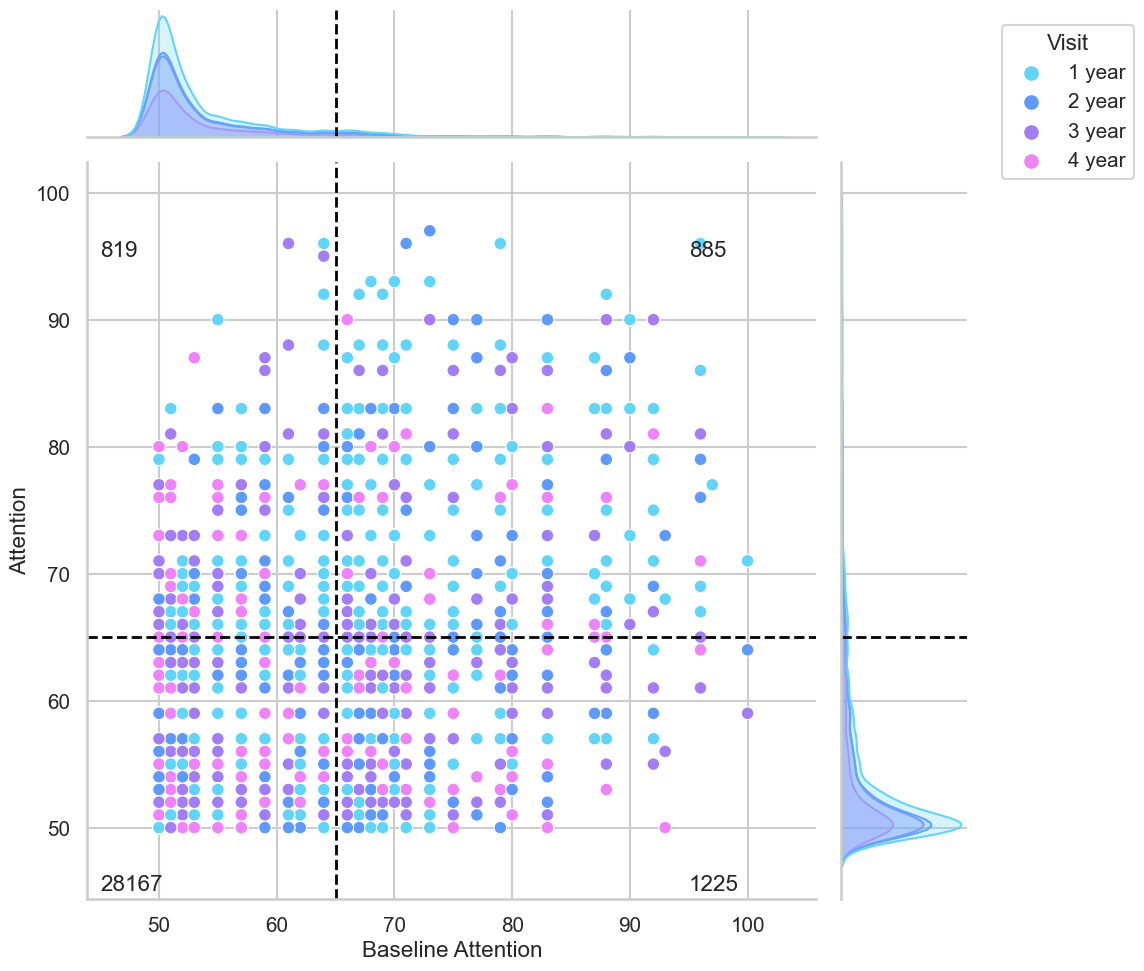

In [8]:
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 95, str(len(low_to_high))), (95, 45, str(len(high_to_low))), (95, 95, str(len(high_to_high)))])

In [9]:
subject_trajectories = dict()
for subject in tqdm(set(trajectory_df['Subject'])):
    trajectory = [None]
    for year in range(1, 5):
        sv_df = trajectory_df.loc[((trajectory_df['Subject'] == subject) & (trajectory_df['Visit'] == '{} year'.format(year)))]
        value = sv_df[mh_outcome].values[0] if len(sv_df)>0 else None
        trajectory.append(value)
        if trajectory[0] is None:
            trajectory[0] = sv_df['Baseline '+mh_outcome].values[0] if len(sv_df)>0 else None
    if any(x is not None and x > threshold for x in trajectory):  # If at least some is greater than 65
        subject_trajectories[subject] = trajectory

100%|████████████████████████████████████████████████████████████████████████████| 11237/11237 [03:38<00:00, 51.49it/s]


In [11]:
plot = pygal.Line(show_legend=False, style=pygal.style.Style(colors=['#61d4fa']))
plot.title = 'Evolution of {} from baseline to 4 year follow-up for > 65 subjects'.format(mh_outcome)
plot.x_labels = ['Baseline', '1 year', '2 year', '3 year', '4 year']
plot.x_title = 'Year'
plot.y_title = mh_outcome + ' (t)'
for subject, trajectory in subject_trajectories.items():
    plot.add(subject, trajectory)
display_html(plot)

### Anxious/Dep.

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

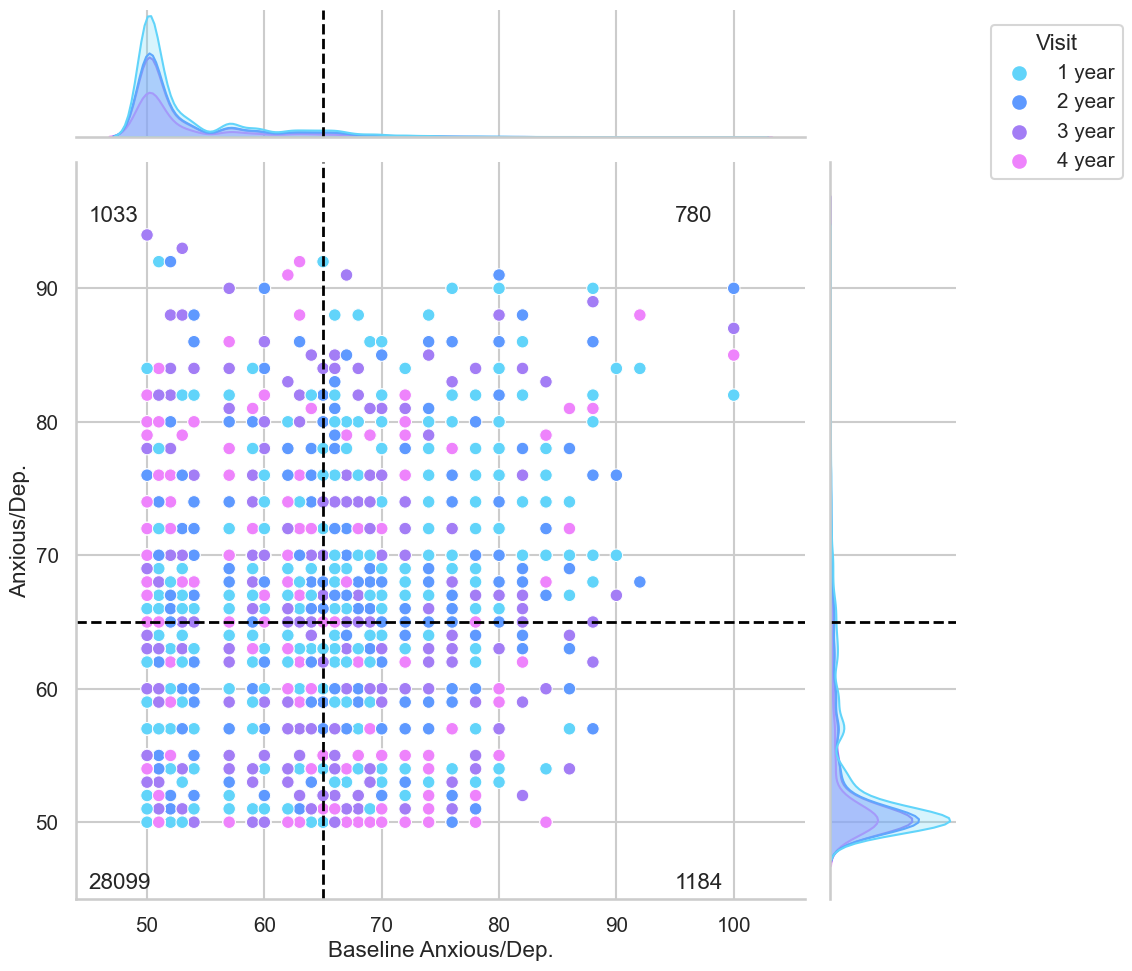

In [13]:
mh_outcome = "Anxious/Dep."
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 95, str(len(low_to_high))), (95, 45, str(len(high_to_low))), (95, 95, str(len(high_to_high)))])

### Depression

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

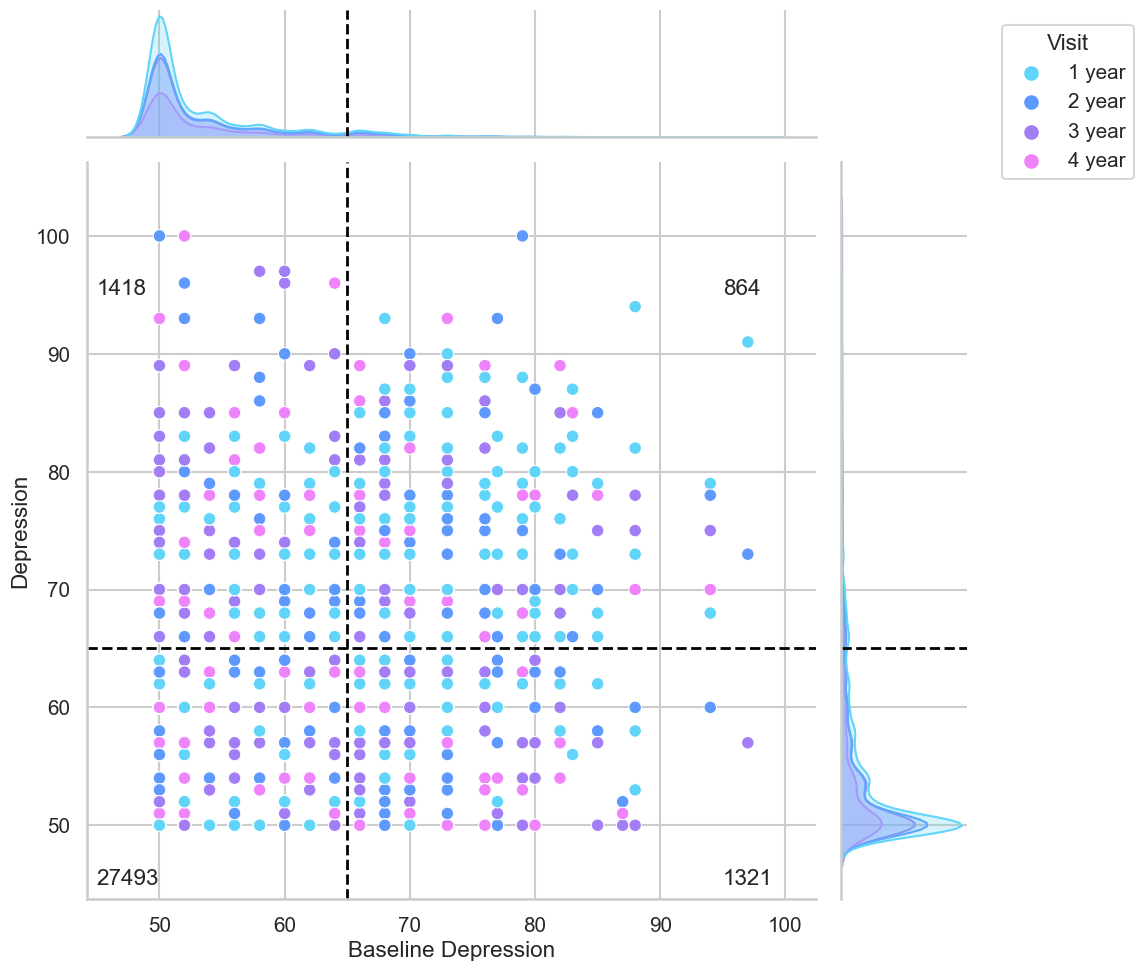

In [14]:
mh_outcome = "Depression"
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 95, str(len(low_to_high))), (95, 45, str(len(high_to_low))), (95, 95, str(len(high_to_high)))])

### Somatic

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

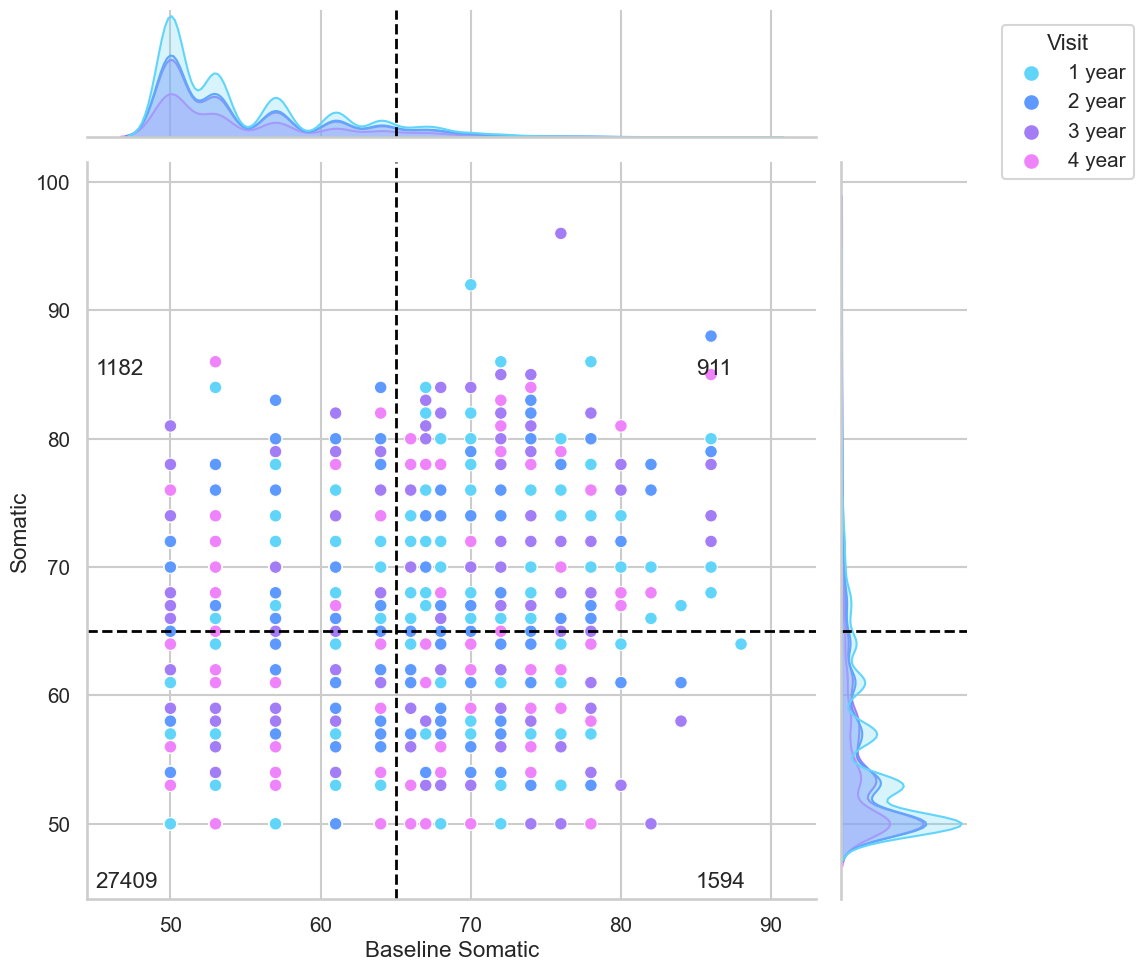

In [17]:
mh_outcome = "Somatic"
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 85, str(len(low_to_high))), (85, 45, str(len(high_to_low))), (85, 85, str(len(high_to_high)))])

### Social

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

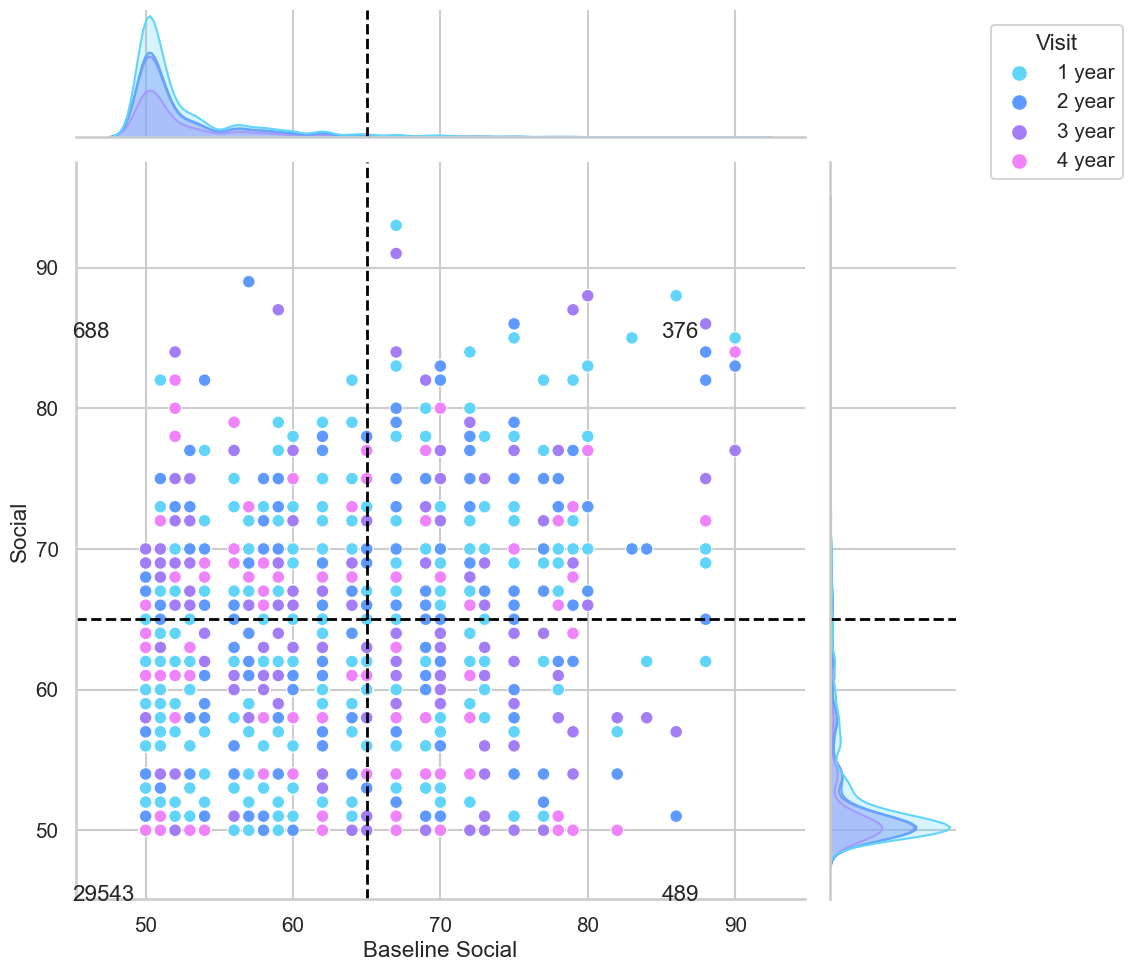

In [18]:
mh_outcome = "Social"
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 85, str(len(low_to_high))), (85, 45, str(len(high_to_low))), (85, 85, str(len(high_to_high)))])

### Rule-breaking

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

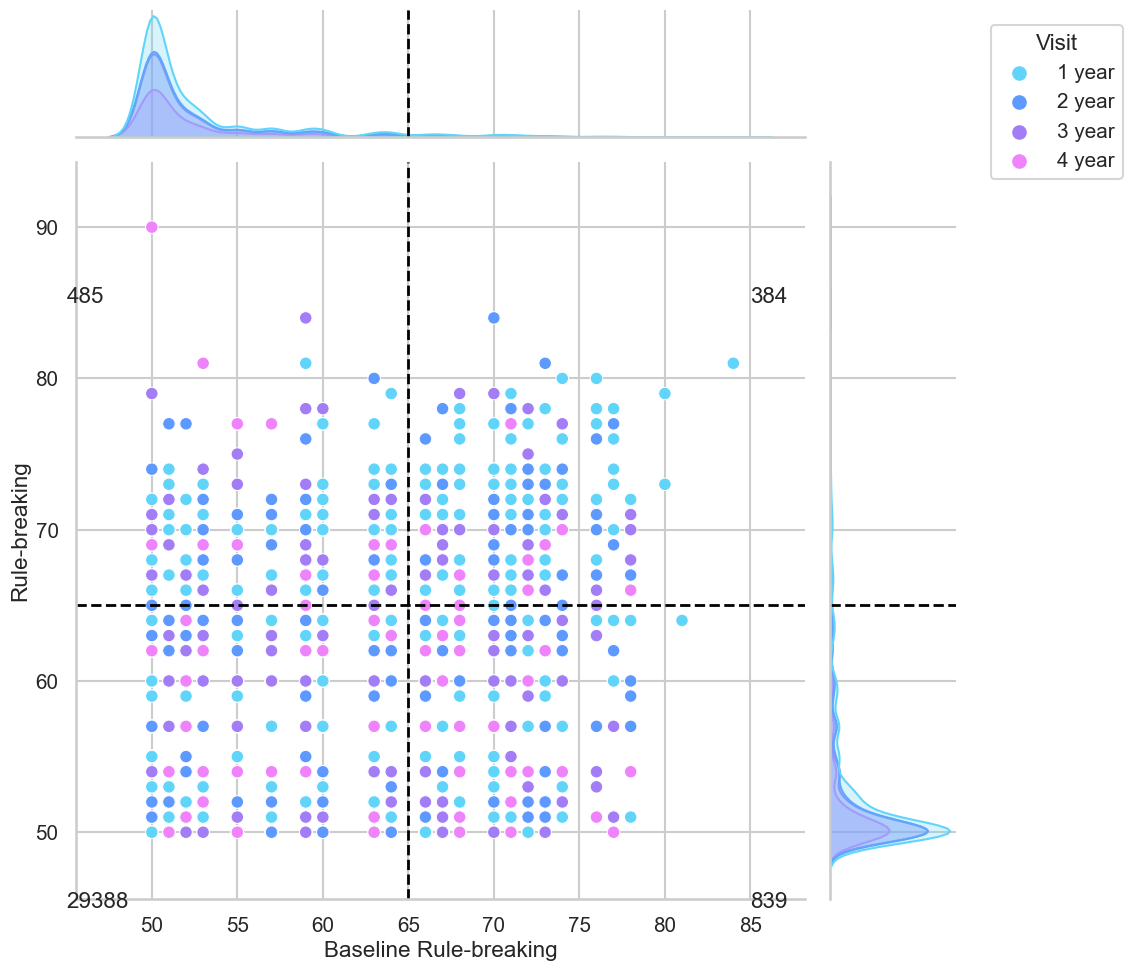

In [20]:
mh_outcome = "Rule-breaking"
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 85, str(len(low_to_high))), (85, 45, str(len(high_to_low))), (85, 85, str(len(high_to_high)))])

### Aggressive

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

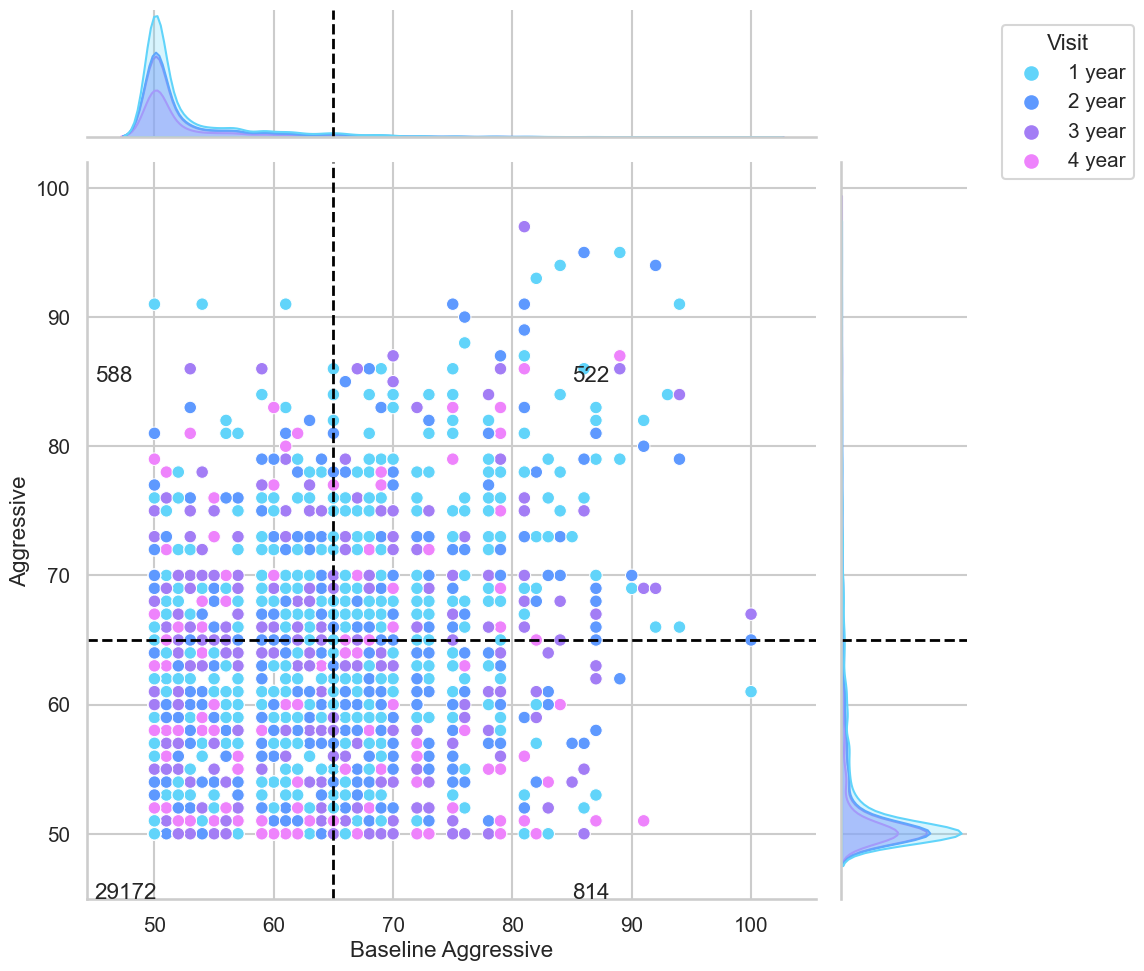

In [21]:
mh_outcome = "Aggressive"
low_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] <= threshold)]
low_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] <= threshold) & (trajectory_df[mh_outcome] > threshold)]
high_to_low = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] <= threshold)]
high_to_high = trajectory_df.loc[(trajectory_df['Baseline '+mh_outcome] > threshold) & (trajectory_df[mh_outcome] > threshold)]
palette = ['#61d4fa', '#5e99ff', '#a37df5', '#ee83fc']
plot_jointplot(trajectory_df, x_col='Baseline '+mh_outcome, y_col=mh_outcome, hue_col='Visit', figsize=(10, 10), palette=palette, refline=(threshold, threshold), 
               text_labels=[(45, 45, str(len(low_to_low))), (45, 85, str(len(low_to_high))), (85, 45, str(len(high_to_low))), (85, 85, str(len(high_to_high)))])